In [2]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    def forward(self,x,y):
        self.x = x
        self.y = y
        out= x * y
        return out 
    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy
    

In [3]:
class AddLayer:
    def __init__(self):
        pass
    def forward(self, x, y):
        out = x + y
        return out 
    def backward(self, dout):
        dx = dout * 1 
        dy = dout * 1 
        return dx, dy
    

In [4]:
apple = 100
apple_num = 2
orange = 150 
orange_num = 3
tax = 1.1
#layer 
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()


In [5]:
#forward
apple_price = mul_apple_layer.forward(apple,apple_num) 
orange_price = mul_orange_layer.forward(orange, orange_num) 
all_price = add_apple_orange_layer.forward(apple_price,orange_price)
price = mul_tax_layer.forward(all_price, tax)

In [9]:
#backward 
dprice = 1 
dall_price, dtax = mul_tax_layer.backward(dprice)  
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num =  mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

In [10]:
print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
### параметрүүд
# Хэдэн удаа оролтын датагаар моделийг сургах
EPOCH = 10          
# 1 удаад оруулах оролтын датаны хэмжээ
BATCH_SIZE = 50
# Learning Rate
LR = 0.001              
# MNIST датаг татах эсэх 
DOWNLOAD_MNIST = True  

In [207]:
# Mnist digits dataset
batch_size = 32
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     
    # this is training data
    transform=torchvision.transforms.ToTensor(),    
    # torch.FloatTensor of shape (Color x Height x Width) and 
    # normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        
)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_data = torchvision.datasets.MNIST(root='./mnist', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [208]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist/
    Split: Train
    StandardTransform
Transform: ToTensor()

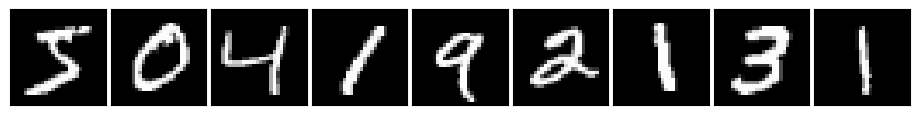

In [209]:
# plot example
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(train_data.data[i].numpy(), cmap='gray')

In [210]:
# plot one example
print(train_data.data.size())                 # (60000, 28, 28)
print(train_data.targets.size())               # (60000)
     
torch.Size([60000, 28, 28])
torch.Size([60000])

torch.Size([60000, 28, 28])
torch.Size([60000])


torch.Size([60000])

In [211]:
test_x = Variable(torch.unsqueeze(test_data.data, dim=1)).type(torch.FloatTensor)[:2000]/255.   
# shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_data.targets[:2000]

In [212]:
# implementation
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=None, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=128*7*7,out_features=50, bias=False),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(in_features=50, out_features=10, bias=True)
        ) 
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)
        output = self.fc(x)
        return output, x
     

In [213]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
device

device(type='cuda')

In [214]:
cnn = CNN().cuda()
print(cnn)  

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=6272, out_features=50, bias=False)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [215]:
from torchinfo import summary
stats = summary(cnn,(1,1,28,28),verbose=2)
print(stats)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 128, 7, 7]            --
│    └─0.weight                                                    ├─288
│    └─0.bias                                                      ├─32
│    └─3.weight                                                    ├─18,432
│    └─3.bias                                                      ├─64
│    └─6.weight                                                    ├─73,728
│    └─6.bias                                                      └─128
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    │    └─weight                                                 ├─288
│    │    └─bias                                                   └─32
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14] 

In [216]:
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR                                                                                                                                                     )   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss() 

In [217]:
# for visualization
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer');
    plt.show(); 
    #plt.pause(0.01)

In [218]:
plt.ion()

In [219]:
# training
test_x = test_x.to(device)
test_y = test_y.to(device)
best_accuracy = 0
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        optimizer.zero_grad
        # clear gradients for this training step
        x = x.to(device)
        y = y.to(device)

        # forward pass
        output =  cnn(x)[0]
        loss = loss_func(output,y)    
        # backward pass
        loss.backward()
        optimizer.step()
        #Visualization
        if step % 400 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                torch.save(cnn,'best_model.pt')
                torch.save(cnn.state_dict(),'best_model_parameters.pt')
            print('step:{}'.format(step), '| loss:{:.4f}'.format(loss.data), '| test accuracy: {:.2f}'.format(accuracy) ) 

            # # Visualization of trained flatten layer (T-SNE)
            # tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
            # plot_only = 500
            # low_dim_embs = tsne.fit_transform(last_layer.cpu().data.numpy()[:plot_only, :])
            # labels = test_y.cpu().numpy()[:plot_only]
            # plot_with_labels(low_dim_embs, labels)
#plt.ioff()
print('best accuracy: {:.2f}'.format(best_accuracy))

step:0 | loss:2.2965 | test accuracy: 0.10
step:400 | loss:2.3204 | test accuracy: 0.55
step:800 | loss:1.5069 | test accuracy: 0.48
step:1200 | loss:2.3405 | test accuracy: 0.10
step:1600 | loss:2.4264 | test accuracy: 0.10
step:0 | loss:2.4421 | test accuracy: 0.09
step:400 | loss:2.3260 | test accuracy: 0.12
step:800 | loss:2.3273 | test accuracy: 0.10
step:1200 | loss:2.4417 | test accuracy: 0.11
step:1600 | loss:2.3260 | test accuracy: 0.11
step:0 | loss:2.3440 | test accuracy: 0.10
step:400 | loss:2.3391 | test accuracy: 0.11
step:800 | loss:2.3203 | test accuracy: 0.10
step:1200 | loss:2.2540 | test accuracy: 0.10
step:1600 | loss:2.2743 | test accuracy: 0.11
step:0 | loss:2.3360 | test accuracy: 0.11
step:400 | loss:2.2716 | test accuracy: 0.11
step:800 | loss:2.3099 | test accuracy: 0.10
step:1200 | loss:2.3920 | test accuracy: 0.12
step:1600 | loss:2.3002 | test accuracy: 0.10
step:0 | loss:2.3333 | test accuracy: 0.11
step:400 | loss:2.3577 | test accuracy: 0.12
step:800 | l

KeyboardInterrupt: 

In [156]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for x, y in test_loader:
        # calculate outputs by running images through the network 
        x = x.to(device)
        y = y.to(device)
        outputs = cnn(x)[0]
        # the class with the highest energy is what we choose as prediction
        predicted = torch.max(outputs.data, 1)[1]
        total += y.size(0)
        correct += (predicted == y).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 23 %


In [163]:
# model = torch.load('./best_model.pt')
# model.eval()
# model = model.to(device)
# stat = summary(model)
# print(stat)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       416
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       12,832
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-2                        --
│    └─Linear: 2-7                       78,400
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      510
Total params: 92,158
Trainable params: 92,158
Non-trainable params: 0


In [171]:
model = torch.load('./best_model.pt')
model.eval()
model = model.to(device)
correct = 0
total = 0
for x,y in test_loader:
    x = x.to(device)
    y = y.to(device)
    output = model(x)[0]
    print("output",output)
    predticted = torch.max(output.data,1)[1]
    total +=y.size(0)
    print(predicted,y)
    correct += (predicted == y).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

output tensor([[-1.6751e+01, -2.1256e+01, -1.0370e+01,  1.4442e+01, -2.6685e+01,
          2.8183e+00, -3.8260e+01,  4.2409e+01, -3.9042e+00,  1.5009e+01],
        [ 6.1046e+00,  9.1853e+00,  1.4567e+01, -5.2477e+00, -9.0629e+00,
         -1.3940e+01,  1.0833e+01, -1.7073e+01, -5.0005e+00, -1.2094e+01],
        [-1.4559e+00,  1.3899e+01, -3.6330e+00, -8.0635e+00, -1.9468e+00,
         -7.4585e+00,  4.9790e+00, -9.8239e+00,  1.7165e+00, -8.8345e+00],
        [ 6.3657e+00, -2.5402e+00, -3.3042e+00,  1.4555e+00, -7.4057e+00,
          1.4898e+00, -1.7071e+00, -1.5841e+00,  1.5381e+00, -4.4349e-01],
        [-7.2175e+00, -6.7089e+00,  2.3904e+00, -9.4411e+00,  1.1990e+01,
         -4.5355e-01, -2.0105e+00, -3.5687e-01, -2.5330e+00,  8.4313e+00],
        [-8.7683e-01,  1.3677e+01, -2.8439e+00, -8.0400e+00, -1.9545e+00,
         -7.5515e+00,  4.4446e+00, -9.9268e+00,  2.1942e+00, -1.0020e+01],
        [-3.8972e+00, -1.7028e+00, -5.0495e-01, -2.3627e+00,  3.0419e+00,
          6.4679e-01, -2.

RuntimeError: The size of tensor a (16) must match the size of tensor b (32) at non-singleton dimension 0

In [165]:
# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].cpu().data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].cpu().numpy(), 'real number')

[7 8 1 8 8 1 8 8 8 8] prediction number
[7 2 1 0 4 1 4 9 5 9] real number


In [166]:
cnn.conv[0].weight.grad[0]
cnn.conv[0].weight[0]
cnn.conv[0].bias.grad
cnn.conv[0].bias

Parameter containing:
tensor([-1.8721, -2.1238, -1.9910, -1.1325, -1.6394, -1.0231, -1.8737, -1.3792,
        -2.2135, -1.8976, -1.9058, -2.1026, -1.8898, -2.1103, -2.0814, -1.8860],
       device='cuda:0', requires_grad=True)